In [86]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [122]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 20

In [88]:
#load dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Image_dataset",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
    )

Found 2475 files belonging to 2 classes.


In [89]:
#explore dataset
class_names = dataset.class_names
class_names

['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy']

In [91]:
len(dataset), 78*32

(78, 2496)

In [92]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())
    print(image_batch[0].shape)

(32, 256, 256, 3)
[0 1 1 0 1 1 1 0 0 1 0 1 1 0 1 1 1 0 0 1 1 1 1 0 0 1 1 0 0 1 1 1]
(256, 256, 3)


In [93]:
dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

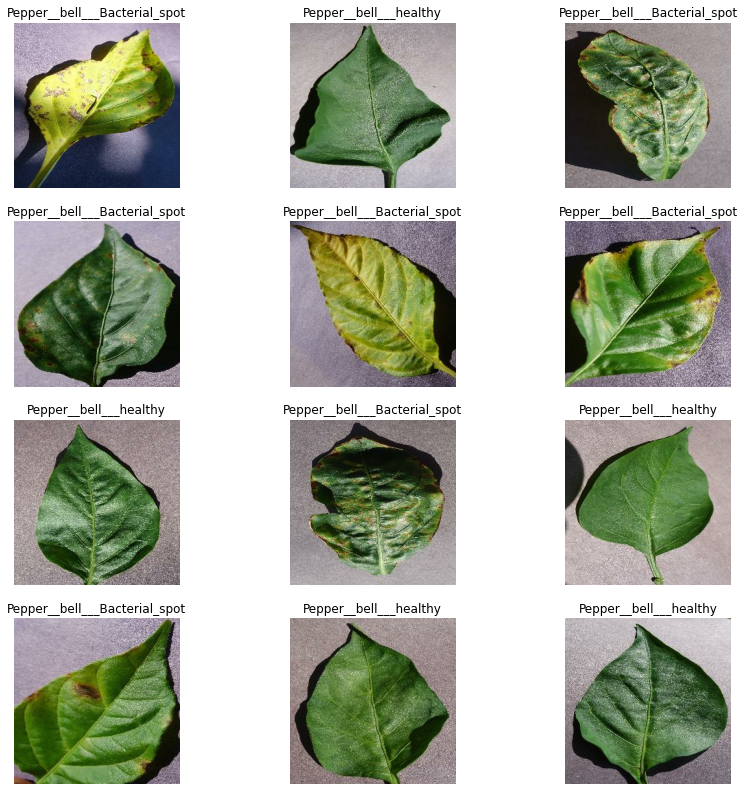

In [94]:
#visualize dataset
plt.figure(figsize=(14, 14))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(4, 3, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [95]:
#train_val_split
len(dataset)

78

In [96]:
train_size = 0.8
len(dataset)*train_size 

62.400000000000006

In [101]:
train_set = dataset.take(62)
len(train_set)

62

In [102]:
test_and_val_set = dataset.skip(62)
len(test_and_val_set)

16

In [103]:
val_size = 0.1
len(dataset)*val_size

7.800000000000001

In [104]:
val_set = test_and_val_set.take(7)
len(val_set)

7

In [105]:
test_set = test_and_val_set.skip(7)
len(test_set)

9

In [106]:
def train_val_test_split(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_set = ds.take(train_size)    
    val_set = ds.skip(train_size).take(val_size)
    test_set = ds.skip(train_size).skip(val_size)
    
    return train_set, val_set, test_set

In [107]:
train_set, val_set, test_set = train_val_test_split(dataset)

In [108]:
len(train_set), len(val_set), len(test_set)

(62, 7, 9)

In [109]:
train_set = train_set.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_set = val_set.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_set = test_set.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [111]:
len(train_set), len(val_set), len(test_set)

(62, 7, 9)

In [112]:
#pre-process
#scale
resize_and_rescale_layer = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255),
])

In [113]:
#augment using flip & rotate to prevent overfit
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [114]:
train_set = train_set.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [123]:
#train model
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2

model = models.Sequential([
    resize_and_rescale_layer,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [124]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_9 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_34 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_34 (MaxPoolin  (32, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_35 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_35 (MaxPoolin  (32, 62, 62, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_36 (Conv2D)          (32, 60, 60, 64)        

In [125]:
#compile model
model.compile(
    optimizer = "adam",
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ["accuracy"]
)

In [126]:
history = model.fit(
    train_set,
    batch_size = BATCH_SIZE,
    validation_data = val_set,
    verbose= 1,
    epochs = EPOCHS,
)

Epoch 1/20
62/62 [==============================] - 25s 387ms/step - loss: 0.6695 - accuracy: 0.6133 - val_loss: 0.6166 - val_accuracy: 0.7411
Epoch 2/20
62/62 [==============================] - 23s 382ms/step - loss: 0.4895 - accuracy: 0.8054 - val_loss: 0.6826 - val_accuracy: 0.7054
Epoch 3/20
62/62 [==============================] - 24s 379ms/step - loss: 0.2492 - accuracy: 0.9195 - val_loss: 0.0415 - val_accuracy: 0.9866
Epoch 4/20
62/62 [==============================] - 24s 380ms/step - loss: 0.0771 - accuracy: 0.9766 - val_loss: 0.0222 - val_accuracy: 0.9955
Epoch 5/20
62/62 [==============================] - 27s 428ms/step - loss: 0.0370 - accuracy: 0.9903 - val_loss: 0.0378 - val_accuracy: 0.9866
Epoch 6/20
62/62 [==============================] - 27s 433ms/step - loss: 0.0317 - accuracy: 0.9893 - val_loss: 0.1033 - val_accuracy: 0.9420
Epoch 7/20
62/62 [==============================] - 26s 423ms/step - loss: 0.0341 - accuracy: 0.9878 - val_loss: 0.0169 - val_accuracy: 0.9911

In [127]:
scores = model.evaluate(test_set)

9/9 [==============================] - 4s 64ms/step - loss: 0.1667 - accuracy: 0.9896


In [128]:
scores

[0.1667138636112213, 0.9895833134651184]

In [129]:
#Plotting the accuracy & Loss curve
history

In [130]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 62}

In [131]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [132]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

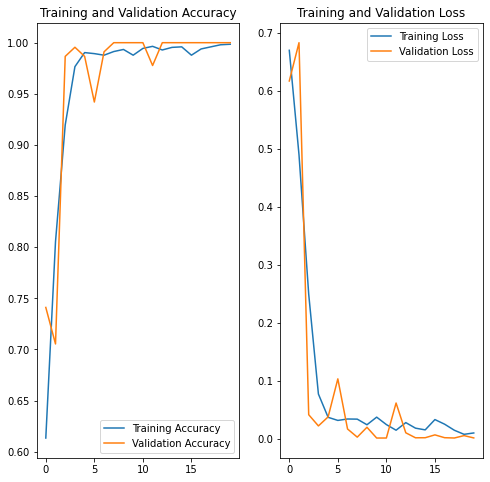

In [133]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Pepper__bell___healthy
1/1 [==============================] - 0s 34ms/step
predicted label: Pepper__bell___healthy


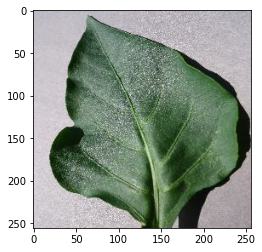

In [137]:
#run prediction on a sample image
import numpy as np
for images_batch, labels_batch in test_set.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [138]:
#write a function for inference
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 24ms/step


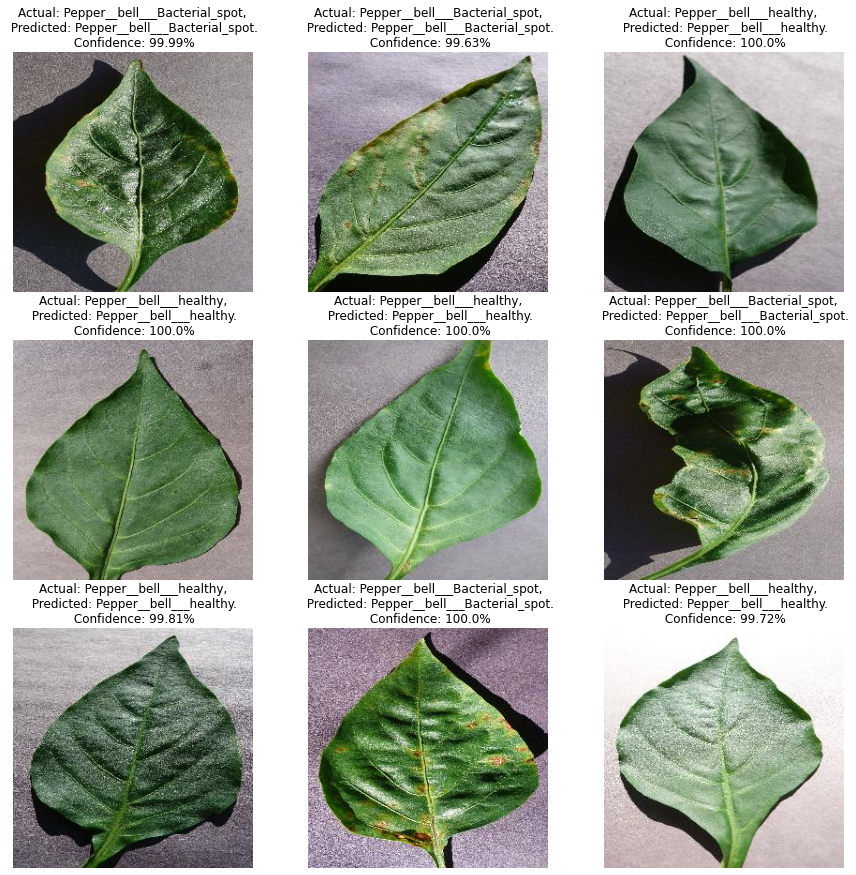

In [139]:
#run inference on few sample images
plt.figure(figsize=(15, 15))
for images, labels in test_set.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [141]:
model_version = 1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets
